Step 1: Data Collection from FRED

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

# Replace with your actual FRED API key
fred = Fred(api_key='fe428f011a7abc6725ed51c40675d4fe')

# Maturity codes from FRED
maturities = {
    '1M': 'DGS1MO', '3M': 'DGS3MO', '6M': 'DGS6MO', '1Y': 'DGS1',
    '2Y': 'DGS2', '3Y': 'DGS3', '5Y': 'DGS5', '7Y': 'DGS7',
    '10Y': 'DGS10', '20Y': 'DGS20', '30Y': 'DGS30'
}

# Fetch time series data
yield_data = pd.DataFrame()
for label, code in maturities.items():
    yield_data[label] = fred.get_series(code)

yield_data.dropna(inplace=True)
yield_data.head()

,1M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
2001-07-31,3.67,3.54,3.47,3.53,3.79,4.06,4.57,4.86,5.07,5.61,5.51
2001-08-01,3.65,3.53,3.47,3.56,3.83,4.09,4.62,4.90,5.11,5.63,5.53
2001-08-02,3.65,3.53,3.46,3.57,3.89,4.17,4.69,4.97,5.17,5.68,5.57
2001-08-03,3.63,3.52,3.47,3.57,3.91,4.22,4.72,4.99,5.20,5.70,5.59
2001-08-06,3.62,3.52,3.47,3.56,3.88,4.17,4.71,4.99,5.19,5.70,5.59


Step 2: Fit the Nelson-Siegel Yield Curve

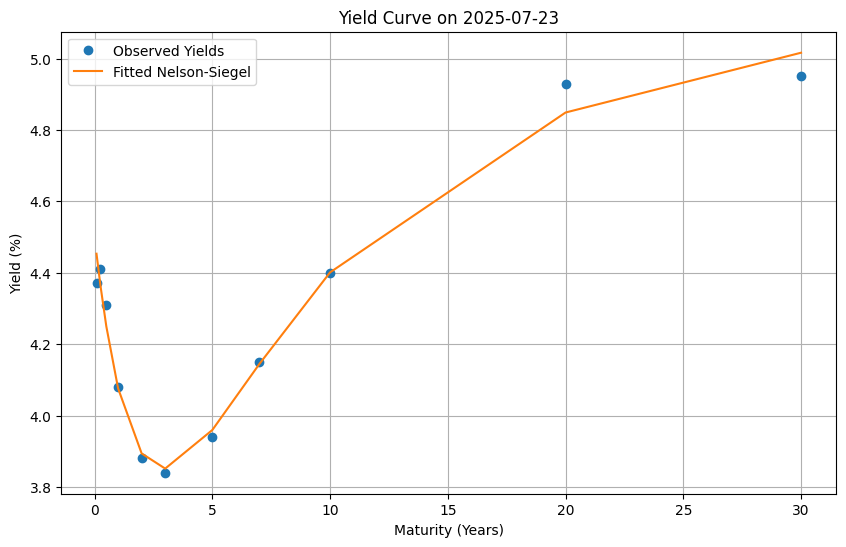

In [2]:
import numpy as np
from scipy.optimize import curve_fit

# Nelson-Siegel formula
def nelson_siegel(tau, beta0, beta1, beta2, lamb):
    tau = np.array(tau)
    term1 = (1 - np.exp(-lamb * tau)) / (lamb * tau)
    term2 = term1 - np.exp(-lamb * tau)
    return beta0 + beta1 * term1 + beta2 * term2

# Choose a recent date
date = yield_data.index[-1]
observed_yields = yield_data.loc[date].values
maturity_labels = list(maturities.keys())
maturities_years = np.array([1/12, 0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])

# Fit Nelson-Siegel curve
popt, _ = curve_fit(
    nelson_siegel,
    maturities_years,
    observed_yields,
    bounds=([0, -10, -10, 0], [10, 10, 10, 5])
)

fitted_curve = nelson_siegel(maturities_years, *popt)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(maturities_years, observed_yields, 'o', label='Observed Yields')
plt.plot(maturities_years, fitted_curve, '-', label='Fitted Nelson-Siegel')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.title(f'Yield Curve on {date.date()}')
plt.grid(True)
plt.legend()
plt.show()

Step 3: Yield Curve Evolution Over Time

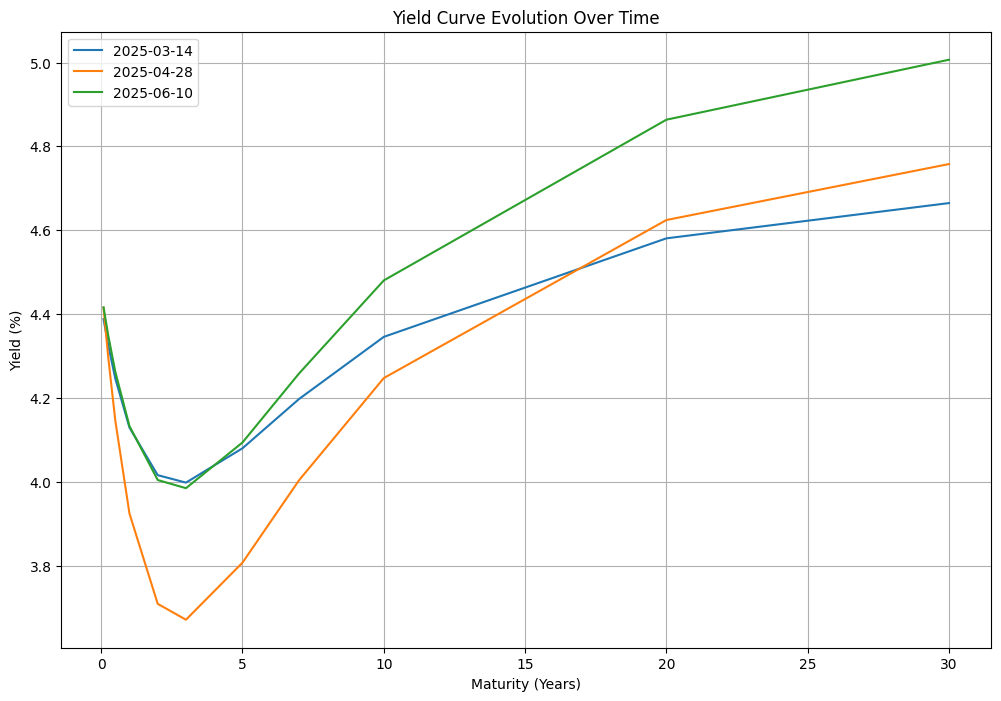

In [3]:
# Plot yield curve shifts every ~30 days over last 3 months
dates_to_plot = yield_data.index[-90::30]

plt.figure(figsize=(12, 8))
for d in dates_to_plot:
    y = yield_data.loc[d].values
    try:
        p, _ = curve_fit(nelson_siegel, maturities_years, y, bounds=([0, -10, -10, 0], [10, 10, 10, 5]))
        curve = nelson_siegel(maturities_years, *p)
        plt.plot(maturities_years, curve, label=str(d.date()))
    except:
        continue

plt.title("Yield Curve Evolution Over Time")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)
plt.show()

Step 4: Basic Curve Shape Classification 

In [4]:
def classify_curve(yields):
    # Simple rule-based classification
    if yields[0] < yields[-1]:
        return "Upward Sloping"
    elif yields[0] > yields[-1]:
        return "Inverted"
    else:
        return "Flat"

# Classify last yield curve
shape = classify_curve(observed_yields)
print(f"Curve Shape on {date.date()}: {shape}")

Curve Shape on 2025-07-23: Upward Sloping


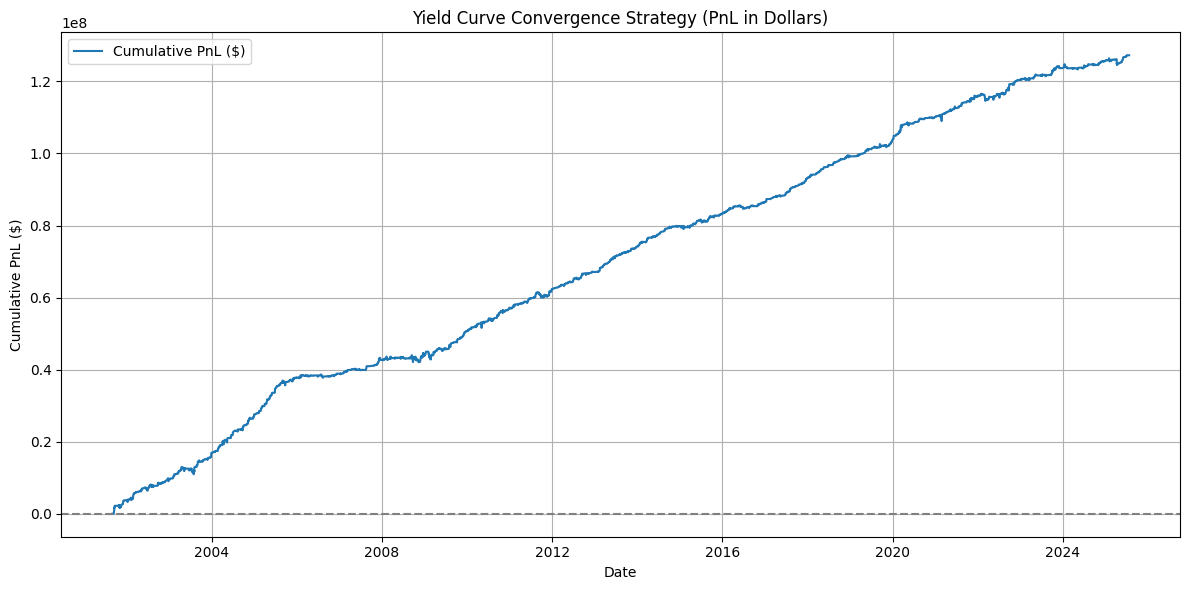

In [10]:
# ---- Strategy Configuration ---- #
notional = 1_000_000        # $1M notional per leg
z_threshold = 2             # Entry threshold
window = 21                 # Lookback window for Z-score
transaction_cost_bp = 0.5   # Cost per leg in basis points
transaction_cost_decimal = transaction_cost_bp / 10_000  # Convert to decimal (e.g. 0.00005)

# ---- Prepare list of maturity labels for indexing ---- #
maturity_labels = list(yield_data.columns)
durations = np.array([1/12, 0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])  # same order as maturity_labels

# ---- Strategy Execution (Dollar PnL) ---- #
strategy_pnl = []
trade_log = []

for t in range(window, len(yield_data) - 1):
    date = yield_data.index[t]
    next_date = yield_data.index[t + 1]
    daily_pnl = 0

    for i in range(1, len(maturity_labels) - 1):
        z = z_scores.iloc[t, i]
        if abs(z) > z_threshold:
            direction = -np.sign(z)

            # Main leg
            dy_main = yield_data.iloc[t + 1, i] - yield_data.iloc[t, i]
            pnl_main = direction * dy_main * durations[i] * notional
            cost_main = transaction_cost_decimal * durations[i] * notional
            pnl_main -= cost_main

            # Hedge legs
            dy1 = yield_data.iloc[t + 1, i - 1] - yield_data.iloc[t, i - 1]
            dy2 = yield_data.iloc[t + 1, i + 1] - yield_data.iloc[t, i + 1]

            pnl_hedge1 = -0.5 * direction * dy1 * durations[i - 1] * notional
            pnl_hedge2 = -0.5 * direction * dy2 * durations[i + 1] * notional
            pnl_hedge1 -= transaction_cost_decimal * durations[i - 1] * notional
            pnl_hedge2 -= transaction_cost_decimal * durations[i + 1] * notional

            total_pnl = pnl_main + pnl_hedge1 + pnl_hedge2
            daily_pnl += total_pnl

            trade_log.append({
                "Entry Date": date,
                "Exit Date": next_date,
                "Maturity": maturity_labels[i],
                "Direction": "Short" if direction == -1 else "Long",
                "Main Yield Change": dy_main,
                "Main PnL ($)": pnl_main,
                "Hedge1": maturity_labels[i - 1],
                "Hedge1 PnL ($)": pnl_hedge1,
                "Hedge2": maturity_labels[i + 1],
                "Hedge2 PnL ($)": pnl_hedge2,
                "Total PnL ($)": total_pnl
            })

    strategy_pnl.append((next_date, daily_pnl))

# ---- Compile Results ---- #
pnl_df = pd.DataFrame(strategy_pnl, columns=["Date", "Daily PnL ($)"]).set_index("Date")
pnl_df["Cumulative PnL ($)"] = pnl_df["Daily PnL ($)"].cumsum()
trade_log_df = pd.DataFrame(trade_log)

# ---- Plot ---- #
plt.figure(figsize=(12, 6))
plt.plot(pnl_df["Cumulative PnL ($)"], label="Cumulative PnL ($)")
plt.axhline(0, linestyle='--', color='gray')
plt.title("Yield Curve Convergence Strategy (PnL in Dollars)")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# ---- Strategy Stats ---- #
from numpy import mean, std

# Sharpe ratio (daily)
daily_returns = pnl_df["Daily PnL ($)"]
sharpe_ratio = mean(daily_returns) / std(daily_returns) * np.sqrt(252)

# Max drawdown
cumulative = pnl_df["Cumulative PnL ($)"]
running_max = cumulative.cummax()
drawdown = cumulative - running_max
max_drawdown = drawdown.min()

# Trade stats
trade_count = len(trade_log_df)
positive_trades = trade_log_df["Total PnL ($)"] > 0
win_rate = positive_trades.mean()
avg_trade_pnl = trade_log_df["Total PnL ($)"].mean()

# Print summary
print("=== Strategy Performance Summary ===")
print(f"Sharpe Ratio         : {sharpe_ratio:.2f}")
print(f"Cumulative PnL ($)   : {cumulative.iloc[-1]:,.2f}")
print(f"Max Drawdown ($)     : {max_drawdown:,.2f}")
print(f"Total Trades         : {trade_count}")
print(f"Win Rate             : {win_rate:.2%}")
print(f"Avg Trade PnL ($)    : {avg_trade_pnl:,.2f}")
print(f"Daily Volatility ($) : {std(daily_returns):,.2f}")

=== Strategy Performance Summary ===
Sharpe Ratio         : 2.43
Cumulative PnL ($)   : 127,238,933.33
Max Drawdown ($)     : -2,122,175.00
Total Trades         : 6975
Win Rate             : 58.42%
Avg Trade PnL ($)    : 18,242.14
Daily Volatility ($) : 138,958.20
